In [240]:
#hide
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [241]:
#default_exp data

# Data

> Methods to load time series data from motion files

In [242]:
#export
from mlchaos.imports import * 
from fastcore.all import *
from timeseries.all import *
import pandas as pd
import numpy as np
from mlchaos.utils import df_slicer
import seaborn as sns

In [243]:
base_path = Path.home()

## Motions defined in files Poincare.plt and index.plt

We call an `item` as a pair `(fname_poincare, fname_index)`. From the Poincare file we get the data of the time series (the x or independent variable) and from the index file we get the y or dependent variable

### Load motion data from poincare file (independent variables)

In [244]:
#export
def load_poincare_maps(fname:Path):
    "Load the data from a Poincare map.\
    Returns a numpy array with a shape (n_orbits, 2, sequence_length). \
    The time column is removed from the data, since it is always multiples of 2*pi"
    df = pd.read_table(fname, sep='\s+', names=['time', 'x', 'y'])
    seq_length = set(df.time).__len__()
    df = df.drop('time', axis=1)
    nparr = df_slicer(df, w=seq_length, s=seq_length)
    return nparr.transpose([0, 2, 1])

In [245]:
fname = Path('../example_data/Poincare.plt')
foo = load_poincare_maps(fname)
bar = pd.read_table(fname, sep='\s+', names=['time', 'x', 'y'])

In [246]:
seq_len = set(bar.time).__len__()
test_eq(foo.shape[2], seq_len)

In [247]:
test_eq(foo.shape[0], bar.shape[0]/seq_len)

In [248]:
test_eq(foo[0,:,:], bar.drop('time', axis=1)[:seq_len].values.transpose(1,0))

### Load index of the motion from index file (dependent variable)

In [249]:
#export
def load_index_file(fname:Path, index_col=7, allow_multiple=True, uncertainty_index=-1.):
    "Returns the index of an index file. In case the argument `index_col` has more \
    than one value (i.e., it's a list) and allow_multiple is False, the value in `uncertainty_index` will be set \
    for that row of the file."
    indices = pd.read_table(fname,
                         sep='\s+',
                         header=None,
                         usecols=L(index_col),
                         squeeze=True).values
    # indices is a numpy array
    if len(indices.shape) > 1 and not allow_multiple:
        indices = array([x[0] if np.all(x == x[0]) else uncertainty_index for x in indices])
    return indices

In [250]:
fname = Path('../example_data/index.plt')

In [251]:
foo = load_index_file(fname)
test_eq(foo.__class__, np.ndarray)
test_eq(foo.ndim, 1)

In [252]:
foo = load_index_file(fname, index_col=[7,8])
bar = load_index_file(fname, index_col=[7,8], allow_multiple=False)
test_eq(foo.ndim, 2)
test_eq(bar.ndim, 1)

### Load x and y at once from both the Poincare and the index file

In [253]:
#export
@delegates(to=load_index_file, but=['fname'])
def load_poincare_index_pair(fname_poincare:Path, fname_index:Path, **kwargs):
    "Load the x data from a Poincare file and the y data from the index file.\
    If multiple indices are used form the indices file, each sample of the poincare file \
    is replicated once for every possible index associated to every motion. \
    Returns a tuple of 2 numpy arrays: "
    "x : array with a shape (n_samples, n_channels, sequence_length)"
    "y : array with a shape (n_samples)"
    "for the Poincare maps, n_channels is 2 (x and y)"
    x = load_poincare_maps(fname_poincare)
    y = load_index_file(fname_index, **kwargs)
    if y.ndim > 1:
        # Replicate each sample for each index value and assign one index to each replica
        x = x.repeat(y.shape[1], axis=0)
        y = y.flatten()
    return (x, y)

In [254]:
fname_poincare = Path('../example_data/Poincare.plt')
fname_index = Path('../example_data/index.plt')

In [255]:
foo, bar = load_poincare_index_pair(fname_poincare, fname_index)
test_eq(foo.__class__, np.ndarray)
test_eq(bar.__class__, np.ndarray)
test_eq(len(foo), len(bar))

In [256]:
foo, bar = load_poincare_index_pair(fname_poincare, fname_index, index_col=[7,8])
test_eq(len(foo), len(bar))
test_eq(bar.ndim, 1)

### Create TSData object from a list of (Poincare.plt, index.plt) files

In [257]:
#export
class TSDataChaos(TSData):
    @classmethod
    @delegates(to=load_poincare_index_pair)
    def from_poincare_and_index_files(cls, fnames, **kwargs):
        "`fnames` is a list of pairs (poincare_file, index_file), or a single pair."
        self = cls(fnames)
        self.x = []
        self.y = []
        self.dsname = []
        self.fnames = []
        self.ds = []
        xs,ys, dss = [],[],[]
        if isinstance(fnames, L) or isinstance(fnames, list):
            for i, (fn_poincare, fn_index) in enumerate(fnames):
                fn_poincare, fn_index = Path(fn_poincare), Path(fn_index)
                dsname = fn_poincare.parent.name
                x, y = load_poincare_index_pair(fn_poincare, fn_index, **kwargs)
                xs.append(x)
                ys.append(y)
                dss.append(np.repeat(i, len(y))) # Map each item with the dataset it belongs to
                self.fnames.append((fn_poincare, fn_index))
                self.dsname.append(dsname)
            self.x = np.concatenate(xs)
            self.y = np.concatenate(ys)
            self.ds = np.concatenate(dss).squeeze()
        else:
            fn_poincare, fn_index = Path(fnames[0]), Path(fnames[1])
            dsname = fn_poincare.parent.name
            self.fnames.append(fnames)
            self.dsname.append(dsname)
            self.x, self.y = load_poincare_index_pair(fn_poincare, fn_index, **kwargs)
            self.ds = np.repeat(0, len(self.y))
        return self

    @classmethod
    def from_poincare_maps(cls, fnames):
        "`fnames` is a list of paths to Poincare maps. No ys are provided"
        self = cls(fnames)
        self.x = []
        self.y = None
        self.dsname = []
        self.fnames = []
        xs = []
        if isinstance(fnames, list):
            for fn_poincare in fnames:
                x = load_poincare_maps(fn_poincare)
                xs.append(x)
                self.fnames.append((fn_poincare, fn_index))
                self.dsname.append(fn_poincare.parent.name)
            self.x = np.concatenate(xs)
        else:
            fn_poincare = fnames
            self.fnames.append(fn_poincare)
            self.dsname.append(fn_poincare.parent.name)
            self.x = load_poincare_maps(fn_poincare)
        return self

In [258]:
fnames = (Path('../example_data/Poincare.plt'), 
            Path('../example_data/index.plt'))
foo = TSDataChaos.from_poincare_and_index_files(fnames, index_col=5)
foo

TSDataChaos:
 Datasets names (concatenated): ['example_data']
 Filenames:                     [(Path('../example_data/Poincare.plt'), Path('../example_data/index.plt'))]
 Data shape: (3, 2, 200)
 Targets shape: (3,)
 Nb Samples: 3
 Nb Channels:           2
 Sequence Length: 200

In [259]:
test_eq(foo.__class__, TSDataChaos)

In [260]:
bar = TSDataChaos.from_poincare_and_index_files(fnames, index_col=8)
bar

TSDataChaos:
 Datasets names (concatenated): ['example_data']
 Filenames:                     [(Path('../example_data/Poincare.plt'), Path('../example_data/index.plt'))]
 Data shape: (3, 2, 200)
 Targets shape: (3,)
 Nb Samples: 3
 Nb Channels:           2
 Sequence Length: 200

In [261]:
x0, y0 = foo.x[0], foo.y[0]
y0

1.0

In [262]:
test_ne(foo.y, bar.y) 

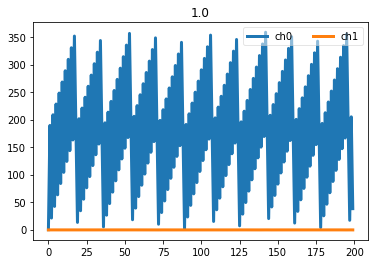

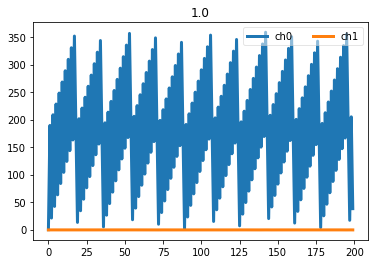

In [263]:
show_timeseries(x0, title=y0)

### Remove uncertain orbits

In [264]:
#export
@patch
def remove_uncertainty(self:TSDataChaos, uncertainty_index=-1):
    self.x = self.x[self.y != uncertainty_index]
    self.ds = self.ds[self.y != uncertainty_index]
    self.y = self.y[self.y != uncertainty_index]

In [265]:
uncertainty_index = -1
fnames = (Path('../example_data/Poincare.plt'), Path('../example_data/index.plt'))
foo = TSDataChaos.from_poincare_and_index_files(fnames)
test_eq(uncertainty_index in foo.y, True)
foo.remove_uncertainty()
test_eq(uncertainty_index in foo.y, False)

## Get items from a TSDataChaos object

In [266]:
#export
def get_motion_items(fnames):
    "get_ts_items return list of tuples. Each tuple corresponds \
    to a timeserie (nump.ndarray) and a label (string). fnames is not \
    an array of paths, but an array of tuples of paths. Each tuple has the \
    path of the Poincare map and the path of the index file"
    data = TSDataChaos.from_poincare_and_index_files(fnames)
    return data.get_items()

### Show labelled initial condition map

In [267]:
#export
@delegates(sns.scatterplot, but=['data', 'x', 'y', 'hue', 'marker'])
def show_labelled_ic_map(poinc_maps:Union[torch.Tensor, np.ndarray]=None,
                         lbls:list=None, **kwargs):
    "Show a scatter plot with the initial conditions (x0, y0) of each Poincare map in \
    `poinc_maps`, coloured with the labels given in `lbls`.'. The argument `poinc_maps` \
    expects a (n_items, n_channels, n_points) numpy array or tensor"
    initial_conditions = poinc_maps[:,:,0]
    qux = pd.DataFrame(initial_conditions, columns=['x0', 'y0'])
    qux['class'] = lbls
    return sns.scatterplot(data=qux, x='x0', y='y0', hue='class', marker='.', **kwargs)

In [268]:
mock_poinc_map = foo = np.random.randn(1000, 2, 100)
mock_lbls = random.choices(['chaotic', 'librational', 'rotational'], k=1000)

<AxesSubplot:xlabel='x0', ylabel='y0'>

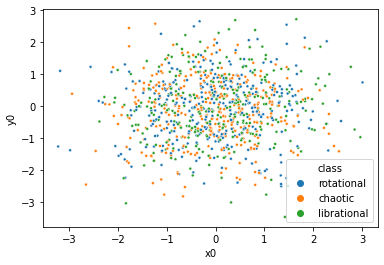

In [269]:
# NOTE: These FLI plots are completely random
show_labelled_ic_map(poinc_maps=mock_poinc_map, lbls=mock_lbls)

Pass kwargs arguments to sns.scatterplot

<AxesSubplot:xlabel='x0', ylabel='y0'>

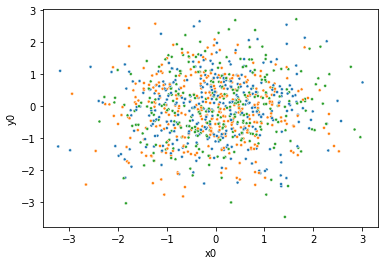

In [270]:
show_labelled_ic_map(poinc_maps=mock_poinc_map, lbls=mock_lbls, legend=False)

## Export 

In [271]:
#hide
from nbdev.export import notebook2script
notebook2script()
beep(1)

Converted cam.ipynb.
Converted core.ipynb.
Converted data.ipynb.
Converted experiments.ipynb.
Converted index.ipynb.
Converted utils.ipynb.
